# Filtering for Traders

### Imports

In [1]:
import sympy as sym
import numpy as np
#import matplotlib.pyplot as plt
from scipy.signal import argrelmax, freqz
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.scale as mscale
import matplotlib.transforms as mtransforms

In [23]:
def period_round(number, dist=0.2):

    rem = 1 - number % 1 if number % 1 > 0.5 else number % 1

    if rem > dist:
        return round(number, 1)
    else:
        return round(number)

In [24]:
def find_cusps(x, y):
    
    dy = y[1:]-y[:-1]
    dx = x[1:]-x[:-1]
    alpha = np.arctan(dy/dx)
    da = alpha[1:]-alpha[:-1]

    cusps_i = argrelmax(da, order=20)[0] + 2
    
    #plt.plot(x, y)
    #plt.scatter(x[cusps_i], y[cusps_i], color='r')

    periods = [period_round(i) for i in 2/x[cusps_i]]
    
    return cusps_i, periods

## Simple Moving Average

In [2]:
period = 10 # Bars
fnq = 0.5 # Nyquist Frequency (bars/day)
tnq = 2 # Nyquist Period (bars/cycle)
t, f, f_c = sym.symbols('t, f, f_c', real=True, positive=True)
k, n, N, P, W = sym.symbols('k, n, N, P, W', real=True, positive=True)

In [3]:
expr = sym.exp(-sym.I*2*t*(1/(P))*sym.pi)
expr

exp(-2*I*pi*t/P)

### Impulse Response

Take the Fourier transform of the filter. For the SMA, the filter coefficients are 1/N (using W in this example). <br>
${\displaystyle F(P)=\frac{1}{W}\int _{0}^{W}e^{\frac{-2\pi i t}{P}}\,dt}$

In [6]:
imp = sym.integrate((1/W)*expr, (t, 0, W))
imp = imp.rewrite(sym.cos).simplify()
imp

P*(sin(2*pi*W/P) + I*cos(2*pi*W/P) - I)/(2*pi*W)

### Frequency Response

In [7]:
imp_func = sym.lambdify(P, imp.subs({
    W: period
}))

In [8]:
n_sweep = np.linspace(1e-6, 1 - 1e-6, 500)
p_sweep = tnq/n_sweep
f_sweep = (1/p_sweep)

In [9]:
imp_plot = imp_func(p_sweep)
phase = np.rad2deg(np.arctan((imp_plot.imag)/imp_plot.real))

In [10]:
test = 16
phase_interp = interp1d(p_sweep, phase)
phase_interp(test)

array(67.49322566)

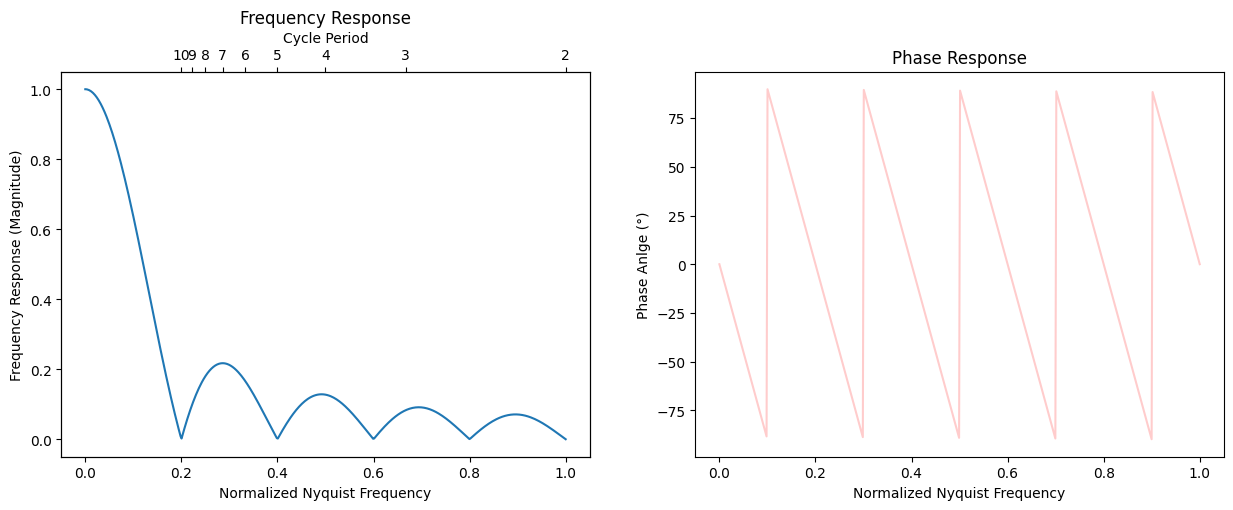

In [11]:
fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(15, 5))
#ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

ax1.plot(n_sweep, np.abs(imp_plot))
ax1.set_xlabel(r"Normalized Nyquist Frequency")
ax1.set_ylabel(r"Frequency Response (Magnitude)")
ax1.set_title('Frequency Response')

new_tick_locations = 2/np.flip(np.arange(2, period+1))

def tick_function(X):
    V = 2/X
    return ["%d" %z for z in V]

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
ax2.set_xlabel(r"Cycle Period")


ax3.plot(n_sweep, np.rad2deg(np.arctan(imp_plot.imag/imp_plot.real)), color='red', alpha=0.2)
ax3.set_title('Phase Response')
ax3.set_xlabel(r"Normalized Nyquist Frequency")
ax3.set_ylabel(r"Phase Anlge (°)")


plt.show()

#plt.plot(n_sweep, 20*np.log10(np.abs(imp_plot)))
#plt.xscale('log')

### Impulse Response - Easy Way

In [12]:
from scipy.signal import freqz

In [13]:
w, h = freqz([1/period for i in range(period)], whole=False, fs=1)

In [14]:
phase = np.arctan2(h.imag,h.real)
f_norm = w/0.5
mag = np.abs(h)
phase_unwrapped = np.unwrap(phase, period=np.pi)
phase_func = interp1d(f_norm, phase_unwrapped)

21.81661564992912
[2.0, 2.5, 3.3333333333333335, 5.0, 10.0]


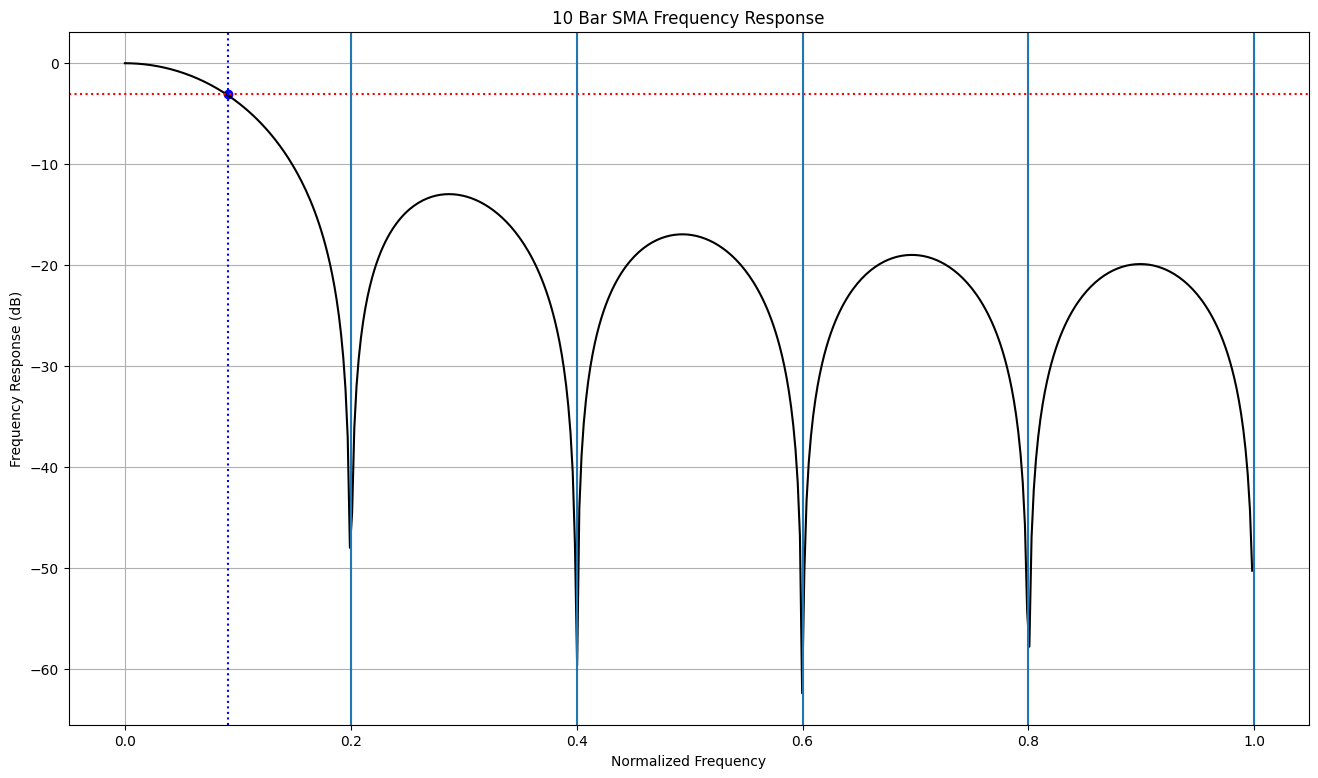

In [15]:
fig, ax = plt.subplots(figsize=(16, 9))
plt.plot(f_norm,20*np.log10(np.abs(mag)), color='black')
plt.axhline(20*np.log10(1/np.sqrt(2)), color='red', linestyle='dotted')
plt.scatter([2.88/(np.pi*period)], [20*np.log10(1/np.sqrt(2))], color='blue')
plt.axvline(2.88/(np.pi*period), color='blue', linestyle='dotted')
print(tnq/(2.88/(np.pi*period)))
for i in [1.0, 0.8, 0.6, 0.4, 0.2]:
    plt.axvline(i)
print([tnq*(1/i) for i in [1.0, 0.8, 0.6, 0.4, 0.2]])
plt.title('10 Bar SMA Frequency Response')
plt.xlabel('Normalized Frequency')
plt.ylabel('Frequency Response (dB)')
plt.grid()

### Phase Delay - Easy Way

21.81661564992912


C:\Users\bjorn\AppData\Local\Temp\ipykernel_25280\2783478577.py:2: RuntimeWarning: invalid value encountered in divide
  plt.plot(f_norm, -(phase_unwrapped/(2*np.pi))/(fnq*f_norm), color='green')


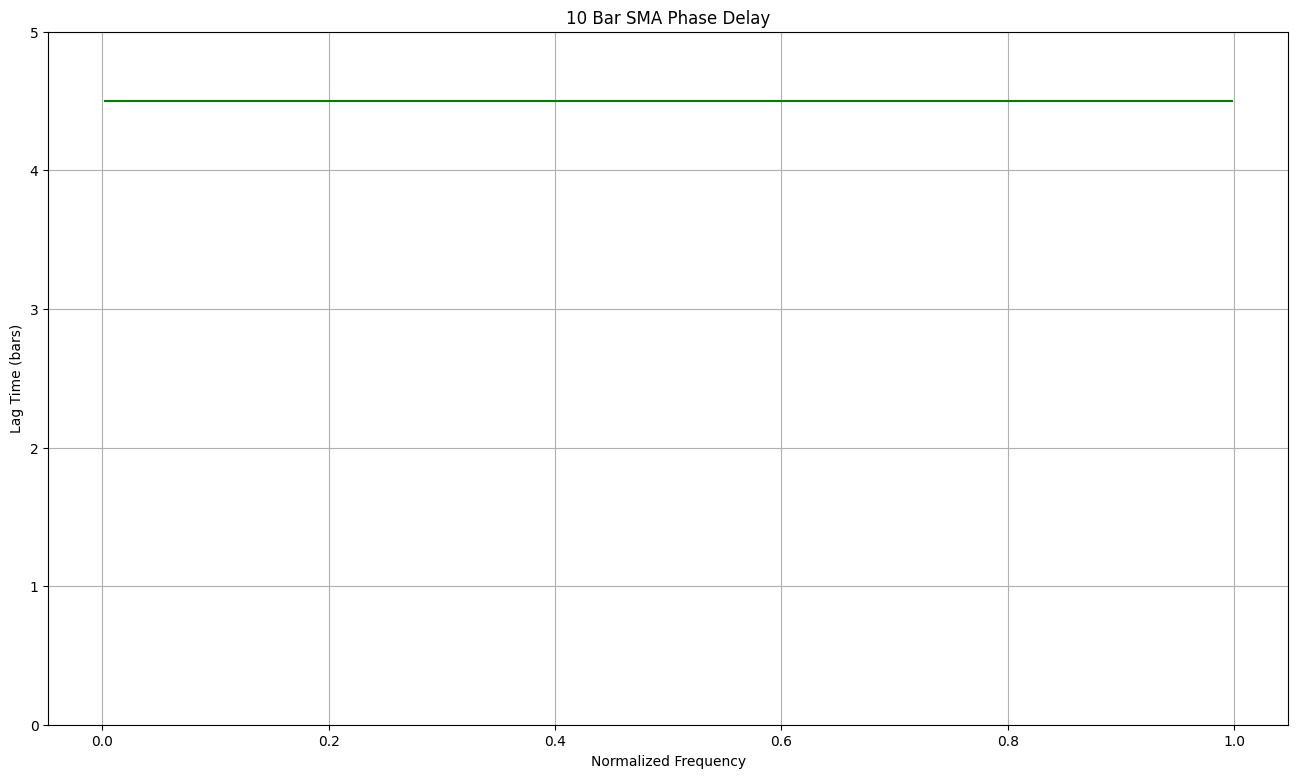

In [16]:
fig, ax = plt.subplots(figsize=(16, 9))
plt.plot(f_norm, -(phase_unwrapped/(2*np.pi))/(fnq*f_norm), color='green')
print(tnq/(2.88/(np.pi*period)))
plt.title('10 Bar SMA Phase Delay')
plt.xlabel('Normalized Frequency')
plt.ylabel('Lag Time (bars)')
plt.ylim(0.0, 5.0)
plt.grid()

## Weighted Moving Average

In [17]:
period = 4 # Bars
fnq = 0.5 # Nyquist Frequency (bars/day)
tnq = 2 # Nyquist Period (bars/cycle)

In [18]:
t, f, f_c = sym.symbols('t, f, f_c', real=True, positive=True)
k, n, N, P, W = sym.symbols('k, n, N, P, W', real=True, positive=True)
expr = sym.exp(-sym.I*2*n*(1/P)*sym.pi/W)
expr

exp(-2*I*pi*n/(P*W))

### Impulse Response

Take the Fourier transform of the filter. <br>
${\displaystyle F(P)=\sum _{n=0}^{N-1}\frac{2n}{W(W+1)}\cdot e^{-{\frac {2\pi i n }{PW}}}}$

In [20]:
imp = sym.summation((1/((W*(W+1))/2))*n*expr, (n, 0, W))
imp = imp.rewrite(sym.cos).simplify()

In [21]:
imp

2*Sum(n*(-I*sin(2*pi*n/(P*W)) + cos(2*pi*n/(P*W))), (n, 0, W))/(W*(W + 1))

In [22]:
sym_mag = sym.sqrt(sym.re(imp)**2 + sym.im(imp)**2) - 1/sym.sqrt(2.0)

### Emperical Expression for Cutoff Frequency

In [23]:
from scipy.optimize import minimize

def constraint(x):
    return x > 0.0

def find_cutoff(window):

    x = imp.subs(W, window)
    sym_mag = ((sym.re(x)**2 + sym.im(x)**2)**0.5 - 1/sym.sqrt(2.0))**2

    func = sym.lambdify(P, sym_mag)
    root = minimize(func, 2.88/period, constraints=[{'type':'ineq', 'fun': constraint}], method='COBYLA')
    print(root.x[0])
    return 1/(tnq*root.x[0])

In [24]:
from scipy.optimize import minimize, newton

def find_cutoff(window):

    # Generate the Filter
    w, h = freqz([i/((window/2)*(window+1)) for i in np.flip(np.arange(1, window+1))], fs=1)

    # Fit an Interpolater
    f = interp1d(w, np.abs(h)-1/np.sqrt(2), bounds_error='false')

    # Find the Zero
    win_f = 1/(2*window)
    zero = newton(f, win_f)

    return 1/zero

In [25]:
n_sweep = np.linspace(1e-6, period, 500)
p_sweep = tnq/n_sweep
f_sweep = (1/p_sweep)

In [26]:
#p_int = np.unique(np.geomspace(4, 1000, 200).astype(int))
p_int = np.arange(4, 1000)

In [27]:
f_cutoff = [1/find_cutoff(i) for i in p_int]

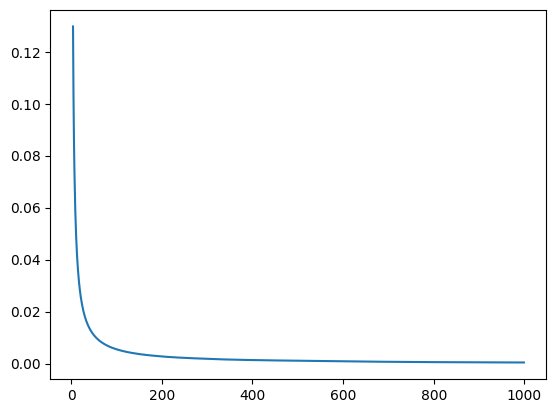

In [28]:
plt.plot(p_int, f_cutoff)

In [29]:
from scipy.optimize import curve_fit

In [30]:
def linear_cutoff_fit(x, a, b, c):

    return c + a/(b-x)

In [32]:
popt, pcov = curve_fit(linear_cutoff_fit, p_int, f_cutoff)

In [33]:
popt

array([-5.48634959e-01, -2.52805718e-01, -4.24077153e-05])

In [34]:
x, a, b, c = sym.symbols('x, a, b, c')
model = 1/(c + a/(b-x))
print(model)
explic = model.subs({
    a: popt[0],
    b: popt[1],
    c: 0
})
explic.simplify()


1/(a/(b - x) + c)


1.82270557703911*x + 0.460790392310782

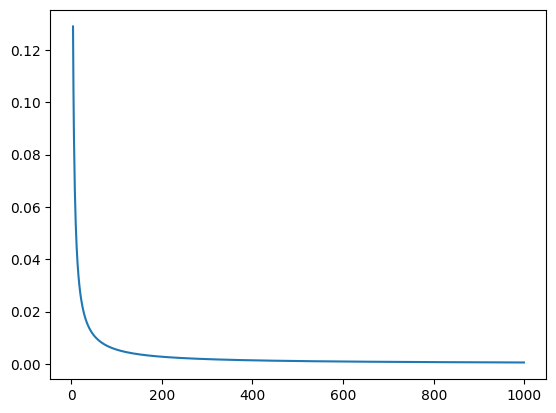

In [36]:
#plt.scatter(p_int, f_cutoff, alpha=0.1)
#plt.plot(p_int, (f_cutoff - linear_cutoff_fit(p_int, popt[0], popt[1], 0))**2)
plt.plot(p_int, linear_cutoff_fit(p_int, popt[0], popt[1], 0))

### Impulse Response - Continued

In [37]:
imp_func = sym.lambdify(P, imp.subs({
    W: period
}))

In [38]:
imp_plot = imp_func(p_sweep)

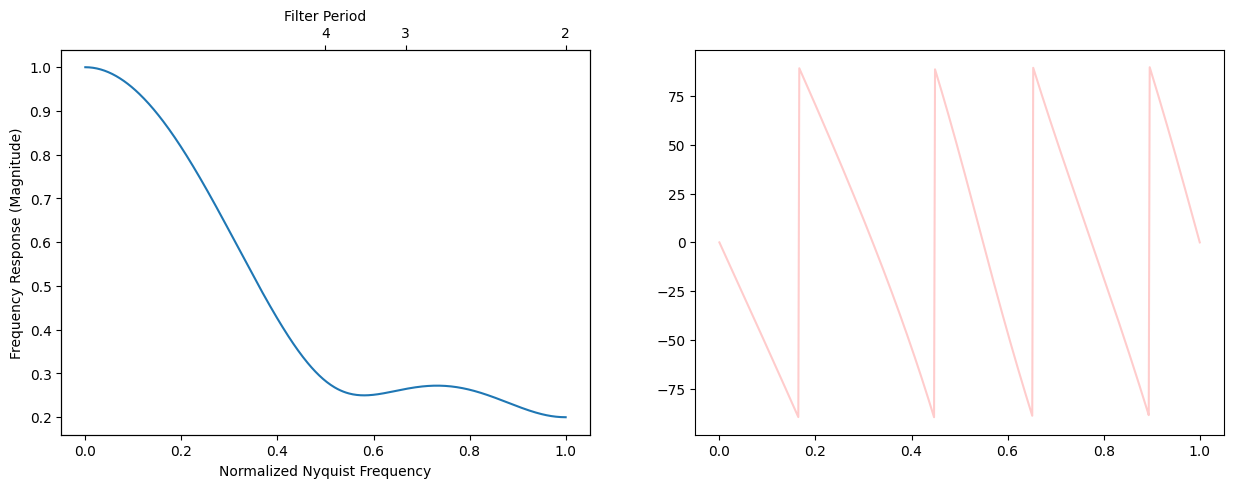

In [39]:
fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(15, 5))
#ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

ax1.plot(np.linspace(0, 1.0, 500), np.abs(imp_plot))
ax1.set_xlabel(r"Normalized Nyquist Frequency")
ax1.set_ylabel(r"Frequency Response (Magnitude)")

new_tick_locations = 2/np.flip(np.arange(2, period+1))

def tick_function(X):
    V = 2/X
    return ["%d" %z for z in V]

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
ax2.set_xlabel(r"Filter Period")

ax3.plot(np.linspace(0, 1, 500), np.rad2deg(np.arctan(imp_plot.imag/imp_plot.real)), color='red', alpha=0.2)
#ax4 = ax3.twiny()
#ax4.set_xscale('reciprocal')
phase_deg = []

plt.show()

#plt.plot(n_sweep, 20*np.log10(np.abs(imp_plot)))
#plt.xscale('log')

### Impulse Response - Easy Way

In [41]:
a = np.arange(1, period+1)
filt = [i/a.sum() for i in np.flip(a)]
lag = period - np.array([i*i for i in a]).sum()/a.sum()

In [42]:
w, h = freqz(filt, fs=1, whole=False)
phase = np.arctan2(h.imag,h.real)
f_norm = w
mag = np.abs(h)
phase_unwrapped = np.unwrap(phase, period=np.pi)
phase_func = interp1d(f_norm, phase_unwrapped)

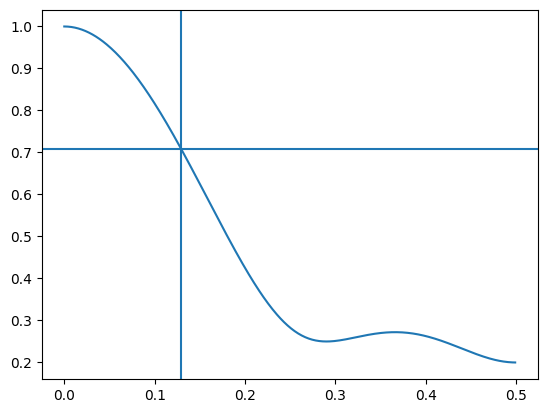

In [45]:
plt.plot(f_norm,mag)
plt.axhline(1/np.sqrt(2.0))
plt.axvline(linear_cutoff_fit(period, *popt))

### Phase Response - Easy Way

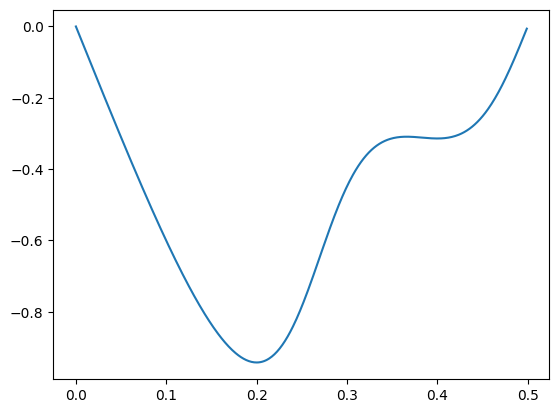

In [46]:
plt.plot(f_norm,phase_unwrapped)

### Phase Delay - Easy Way

C:\Users\bjorn\AppData\Local\Temp\ipykernel_25280\2272981256.py:1: RuntimeWarning: invalid value encountered in divide
  plt.plot(f_norm, (phase_unwrapped/(2*np.pi))/(fnq*f_norm))


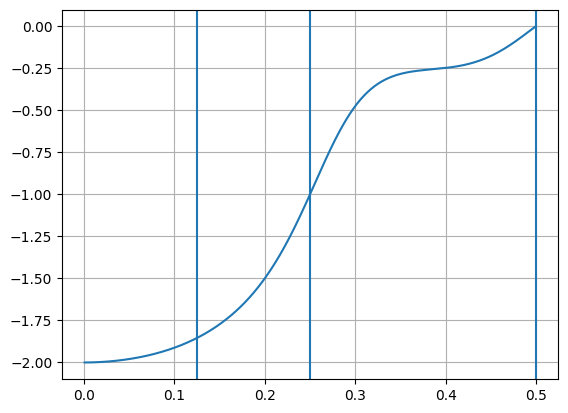

In [48]:
plt.plot(f_norm, (phase_unwrapped/(2*np.pi))/(fnq*f_norm))
plt.axvline(tnq/period)
plt.axvline(tnq/(2*period))
plt.axvline(tnq/(4*period))
plt.grid()

## Exponential Moving Average

In [54]:
a = 0.25 # Bars
fcutt = 1/period # Cuttoff Frequency (bars/day)
fnq = 0.5 # Nyquist Frequency (bars/day)f
tnq = 2 # Nyquist Period (bars/cycle)

t, f, f_c, alpha = sym.symbols('t, f, f_c, alpha', real=True, positive=True)
k, n, N, P, W = sym.symbols('k, n, N, P, W', real=True, positive=True)

In [55]:
expr = sym.exp(-sym.I*2*t*f*sym.pi)
expr

exp(-2*I*pi*f*t)

In [176]:
exponential = (1-alpha)**t

### Impulse Response

Take the Fourier transform of the filter. <br>
${\displaystyle F(P)=\int _{0}^{\infty}(1-\alpha)^{t}e^{\frac{-2\pi i t}{P}}\,dt}$

In [57]:
imp = sym.integrate(exponential*expr, (t, 0, N))
imp

Piecewise((I*(1 - alpha)**N/(2*pi*f*exp(2*I*pi*N*f) + I*exp(2*I*pi*N*f)*log(1 - alpha)) - I/(2*pi*f + I*log(1 - alpha)), Ne(alpha, 1 - exp(2*I*pi*f))), (I*exp(2*I*pi*f)**N/(2*pi*f*exp(2*I*pi*N*f) + I*exp(2*I*pi*N*f)*log(exp(2*I*pi*f))) - I/(2*pi*f + I*log(exp(2*I*pi*f))), True))

In [58]:
imp_func = sym.lambdify(f, (1/area)*imp.subs({
    alpha:a,
    N:1e6
}))

In [59]:
n_sweep = np.linspace(1e-6, 1-1e-6, 500)
p_sweep = tnq/n_sweep
f_sweep = (1/p_sweep)

In [60]:
imp_plot = imp_func(f_sweep)

<lambdifygenerated-3>:2: RuntimeWarning: divide by zero encountered in divide
  return 0.287682072451781*select([not_equal(exp(2*1j*pi*f), 0.75),True], [1.83396777380735e-124939*1j/(2*pi*f*exp(2000000.0*1j*pi*f) - 0.287682072451781*1j*exp(2000000.0*1j*pi*f)) - 1j/(2*pi*f - 0.287682072451781*1j),1j*exp(2*1j*pi*f)**1000000.0/(2*pi*f*exp(2000000.0*1j*pi*f) + 1j*exp(2000000.0*1j*pi*f)*log(exp(2*1j*pi*f))) - 1j/(2*pi*f + 1j*log(exp(2*1j*pi*f)))], default=nan)
<lambdifygenerated-3>:2: RuntimeWarning: invalid value encountered in divide
  return 0.287682072451781*select([not_equal(exp(2*1j*pi*f), 0.75),True], [1.83396777380735e-124939*1j/(2*pi*f*exp(2000000.0*1j*pi*f) - 0.287682072451781*1j*exp(2000000.0*1j*pi*f)) - 1j/(2*pi*f - 0.287682072451781*1j),1j*exp(2*1j*pi*f)**1000000.0/(2*pi*f*exp(2000000.0*1j*pi*f) + 1j*exp(2000000.0*1j*pi*f)*log(exp(2*1j*pi*f))) - 1j/(2*pi*f + 1j*log(exp(2*1j*pi*f)))], default=nan)
<lambdifygenerated-3>:2: RuntimeWarning: invalid value encountered in subtract
  re

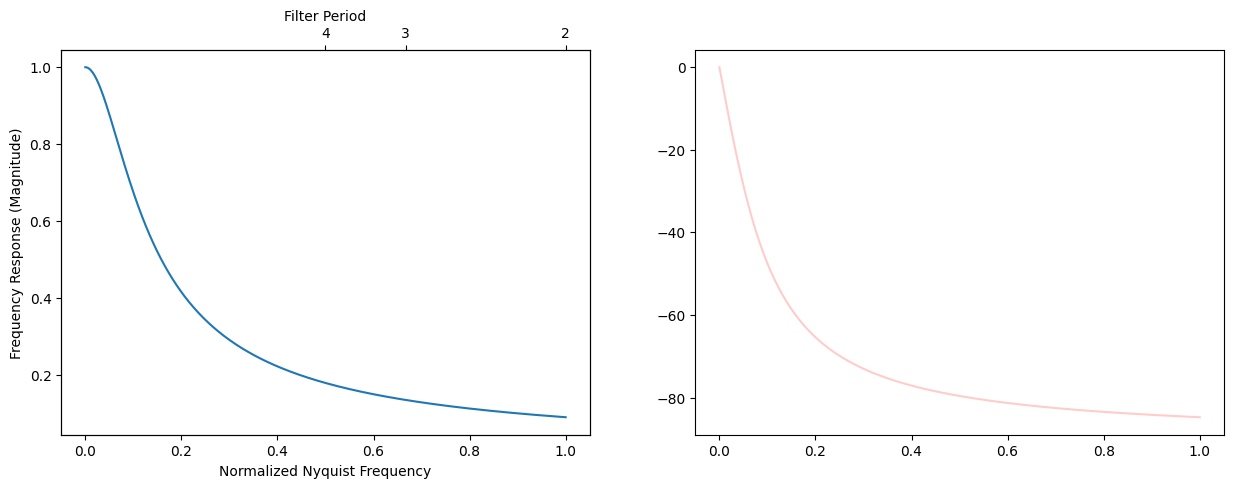

In [61]:
fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(15, 5))
#ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

ax1.plot(n_sweep, np.abs(imp_plot))
ax1.set_xlabel(r"Normalized Nyquist Frequency")
ax1.set_ylabel(r"Frequency Response (Magnitude)")

new_tick_locations = 2/np.flip(np.arange(2, period+1))

def tick_function(X):
    V = 2/X
    return ["%d" %z for z in V]

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
ax2.set_xlabel(r"Filter Period")

ax3.plot(n_sweep, np.rad2deg(np.arctan(imp_plot.imag/imp_plot.real)), color='red', alpha=0.2)
#ax4 = ax3.twiny()
#ax4.set_xscale('reciprocal')
phase_deg = []

plt.show()

#plt.plot(n_sweep, 20*np.log10(np.abs(imp_plot)))
#plt.xscale('log')

### Impulse Response - Easy Way

In [62]:
ind = np.arange(0, 100)
filt = np.array([((1-a)**i) for i in ind])
crit = (tnq/(2*np.pi))*np.arccos(1-(a**2)/(2*(1-a)))
#b, area = iirfilter(1, crit, btype='lowpass')
w, h = freqz(filt, a=1/a, fs=1, whole=False)
phase = np.arctan2(h.imag,h.real)
f_norm = w/0.5
mag = np.abs(h)
phase_unwrapped = np.unwrap(phase, period=np.pi)
phase_func = interp1d(f_norm, phase_unwrapped)

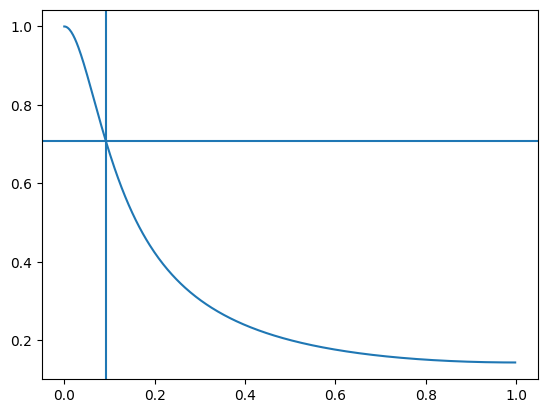

In [63]:
plt.plot(f_norm, mag)
plt.axhline(1/np.sqrt(2))
plt.axvline(crit)

### Phase Delay - Easy Way

C:\Users\bjorn\AppData\Local\Temp\ipykernel_25280\3247328105.py:1: RuntimeWarning: invalid value encountered in divide
  plt.plot(f_norm, (phase/(2*np.pi))/(fnq*f_norm))


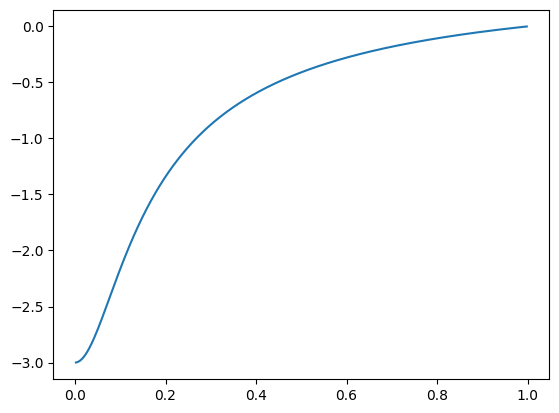

In [64]:
plt.plot(f_norm, (phase/(2*np.pi))/(fnq*f_norm))

## Comparitive Analysis

In [69]:
lag = 10
sma_period = N = round(lag*2 + 1)
wma_period = round((3*N-1)/2)
ema_period = 2/(N + 1)
print('SMA Period: {0}\nWMA Period: {1}\nEMA Alpha: {2}'.format(sma_period, wma_period, round(ema_period, 3)))

SMA Period: 21
WMA Period: 31
EMA Alpha: 0.091


In [70]:
sma_filt = [1/sma_period for i in range(sma_period)]
wma_filt = [i/((wma_period/2)*(wma_period + 1)) for i in np.flip(np.arange(1, wma_period + 1))]
ema_filt = [ema_period*(1 - ema_period)**i for i in range(0, 100)]

In [71]:
ws, sma_res = freqz(sma_filt, fs=1)
ww, wma_res = freqz(wma_filt, fs=1)
we, ema_res = freqz(ema_filt, fs=1)

In [72]:
sma_mag = np.abs(sma_res)
wma_mag = np.abs(wma_res)
ema_mag = np.abs(ema_res)

In [73]:
sma_cut = 2*sma_period*np.pi/2.88
wma_cut = 1/linear_cutoff_fit(wma_period, *popt)
ema_cut = 2*np.pi/np.arccos(1-(ema_period**2)/(2*(1-ema_period)))

In [74]:
print(sma_period, sma_cut)
print(wma_period, wma_cut)
print(ema_cut)

21 45.81489286485115
31 57.10260840558279
65.87362576385435


In [75]:
print(linear_cutoff_fit(wma_period, *popt))

0.01751233486388745


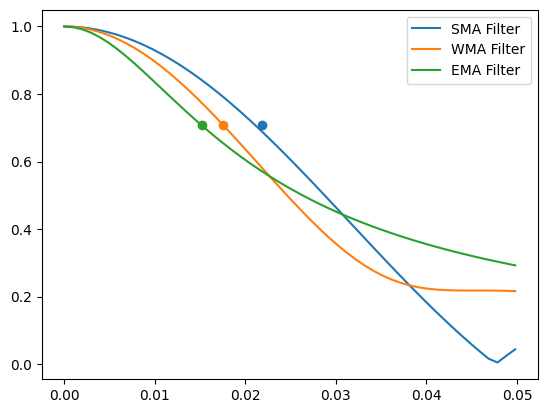

In [76]:
plt.plot(ws[ws<0.05], sma_mag[ws<0.05], label='SMA Filter')
plt.scatter([1/sma_cut], [1/np.sqrt(2)])
plt.plot(ww[ww<0.05], wma_mag[ww<0.05], label='WMA Filter')
plt.scatter([1/56.86], [1/np.sqrt(2)])
plt.plot(we[we<0.05], ema_mag[we<0.05], label='EMA Filter')
plt.scatter([1/ema_cut], [1/np.sqrt(2)])
plt.legend()

## Lags, periods, and cutoff frequencies comparison

In [77]:
import pandas as pd

In [90]:
def lag_func(period, opt='sma'):
    if opt == 'sma':
        return (period-1)/2
    elif opt == 'wma':
        return (period-1)/3
    elif opt == 'ema':
        alpha = 2/(period+1)
        return 1/alpha - 1

In [86]:
def period_func(lag, opt='sma', ret_string=True):
    if opt == 'sma':
        return (2*lag + 1)
    elif opt == 'wma':
        return (3*lag + 1)
    elif opt == 'ema':
        alpha = 1/(1+lag)
        period = round(2/alpha - 1)
        if not ret_string:
            return period
        return '{0} ({1})'.format(period, round(1/(1+lag), 4))

In [87]:
def cutoff_func(period, opt='sma', ret_string=True):
    if opt == 'sma':
        dec_cut = 2*period*np.pi/2.88
    elif opt == 'wma':
        dec_cut = 1/linear_cutoff_fit(period, *popt)
    elif opt == 'ema':
        period = 1/(1+float(period.split(' ')[0]))
        dec_cut = np.pi/np.arccos(1-(period**2)/(2*(1-period)))
    if not ret_string:
        return dec_cut
    return '{0} ({1})'.format(round(dec_cut), round(dec_cut, 1))

In [88]:
comparison = pd.DataFrame()
lags = np.arange(0, 101, 5)
lags[0] = 1
comparison['Lag'] = lags
comparison['SMA Period'] = comparison['Lag'].apply(period_func, opt='sma')
comparison['WMA Period'] = comparison['Lag'].apply(period_func, opt='wma')
comparison['EMA Alpha'] = comparison['Lag'].apply(period_func, opt='ema')

comparison['SMA Cutoff'] = comparison['SMA Period'].apply(cutoff_func, opt='sma')
comparison['WMA Cutoff'] = comparison['WMA Period'].apply(cutoff_func, opt='wma')
comparison['EMA Cutoff'] = comparison['EMA Alpha'].apply(cutoff_func, opt='ema')

In [89]:
comparison

,Lag,SMA Period,WMA Period,EMA Alpha,SMA Cutoff,WMA Cutoff,EMA Cutoff
0,1,3,4,3 (0.5),7 (6.5),8 (7.8),11 (10.8)
1,5,11,16,11 (0.1667),24 (24.0),30 (29.7),36 (36.1)
2,10,21,31,21 (0.0909),46 (45.8),57 (57.1),68 (67.5)
3,15,31,46,31 (0.0625),68 (67.6),85 (84.6),99 (98.9)
4,20,41,61,41 (0.0476),89 (89.4),112 (112.2),130 (130.4)
5,25,51,76,51 (0.0385),111 (111.3),140 (139.8),162 (161.8)
6,30,61,91,61 (0.0323),133 (133.1),168 (167.5),193 (193.2)
7,35,71,106,71 (0.0278),155 (154.9),195 (195.3),225 (224.6)
8,40,81,121,81 (0.0244),177 (176.7),223 (223.1),256 (256.0)
9,45,91,136,91 (0.0217),199 (198.5),251 (251.0),287 (287.5)


### SMA Period, Trading Cycle, and Lag Analysis

In [167]:
trading_periods = np.arange(4, 200)
sma_periods = np.arange(4, 200)

In [168]:
TP, SP = np.meshgrid(trading_period, sma_periods)
L = lag_func(SP)
Lpercent = L/TP
Lpercent.shape

(196, 196)

Text(0.5, 1.0, 'Hypothetical Signal')

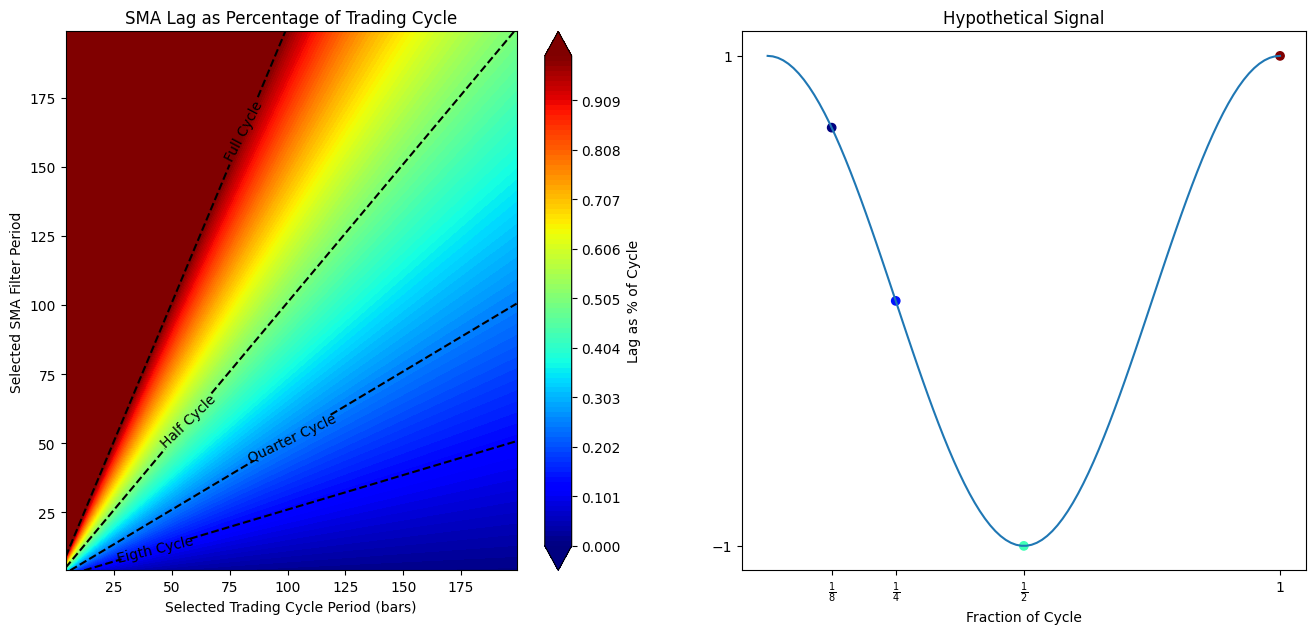

In [169]:
fig, ax = plt.subplots(1, 2, figsize=(16,7))

lookup = {0.125: 'Eigth Cycle', 0.25: 'Quarter Cycle', 0.5: 'Half Cycle', 1.0: 'Full Cycle'}
def fmt(x):
    lab = lookup[x]
    return lab

# Lag Analysis
cont = ax[0].contourf(TP, SP, Lpercent, np.linspace(0.0, 1.0, 100), cmap='jet', extend='both')
line = ax[0].contour(TP, SP, Lpercent, [0.125, 0.25, 0.5, 1.0], colors='k', linestyles='dashed')
ax[0].clabel(line, line.levels, inline=True, fmt=fmt, fontsize=10)
ax[0].set_xlabel('Selected Trading Cycle Period (bars)')
ax[0].set_ylabel('Selected SMA Filter Period')
ax[0].set_title('SMA Lag as Percentage of Trading Cycle')
cbar = plt.colorbar(cont, extend='both')
cbar.set_label('Lag as % of Cycle')

# Hypothetical Signal
theta = np.linspace(0, 2*np.pi, 100)
signal = np.cos(theta)
ax[1].plot(theta, signal)
ax[1].set_yticks([-1, 1])
ax[1].set_xticks([0.125*2*np.pi, 0.25*2*np.pi, 0.5*2*np.pi, 1.0*2*np.pi])
ax[1].set_xticklabels([r"$\frac{1}{8}$", r"$\frac{1}{4}$", r"$\frac{1}{2}$", r"$1$"])
scat = 2*np.pi*np.array([0.125, 0.25, 0.5, 1.0])
ax[1].scatter(scat, np.cos(scat), c=[12.5, 25, 50, 100], cmap='jet')
ax[1].set_xlabel('Fraction of Cycle')
ax[1].set_title('Hypothetical Signal')

### WMA Period, Trading Cycle, and Lag Analysis

In [170]:
trading_periods = np.arange(4, 200)
wma_periods = np.arange(4, 200)

In [171]:
TP, SP = np.meshgrid(trading_period, wma_periods)
L = lag_func(SP, opt='wma')
Lpercent = L/TP
Lpercent.shape

(196, 196)

Text(0.5, 1.0, 'Hypothetical Signal')

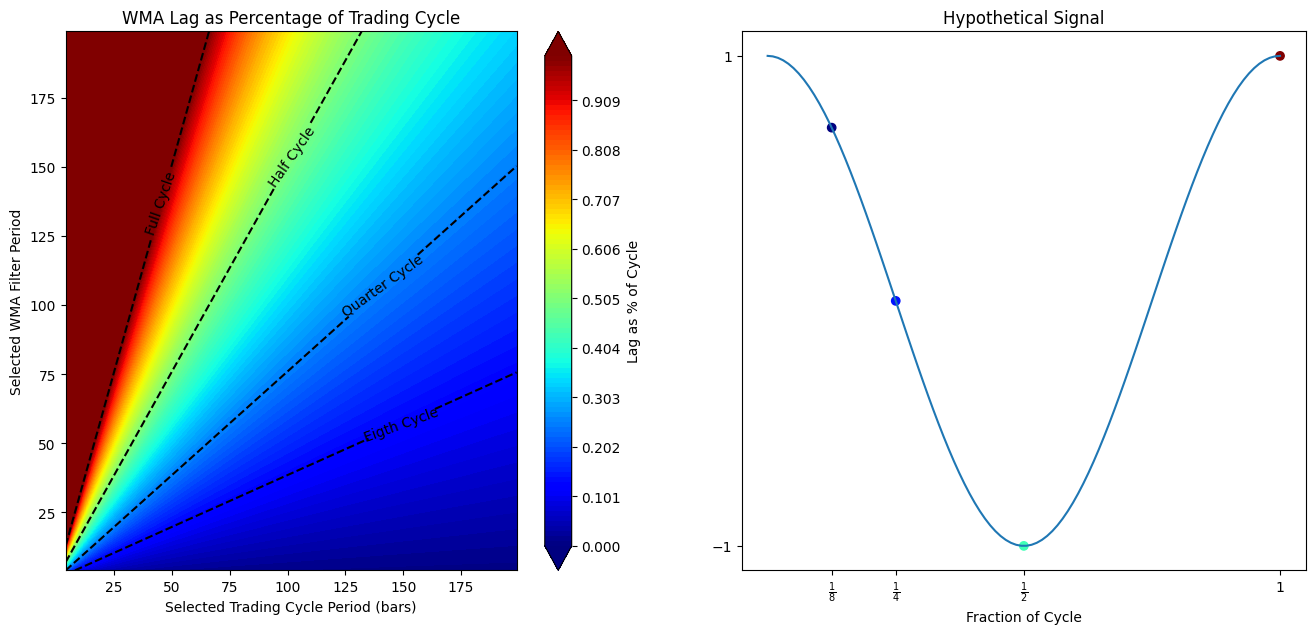

In [172]:
fig, ax = plt.subplots(1, 2, figsize=(16,7))

lookup = {0.125: 'Eigth Cycle', 0.25: 'Quarter Cycle', 0.5: 'Half Cycle', 1.0: 'Full Cycle'}
def fmt(x):
    lab = lookup[x]
    return lab

# Lag Analysis
cont = ax[0].contourf(TP, SP, Lpercent, np.linspace(0.0, 1.0, 100), cmap='jet', extend='both')
line = ax[0].contour(TP, SP, Lpercent, [0.125, 0.25, 0.5, 1.0], colors='k', linestyles='dashed')
ax[0].clabel(line, line.levels, inline=True, fmt=fmt, fontsize=10)
ax[0].set_xlabel('Selected Trading Cycle Period (bars)')
ax[0].set_ylabel('Selected WMA Filter Period')
ax[0].set_title('WMA Lag as Percentage of Trading Cycle')
cbar = plt.colorbar(cont, extend='both')
cbar.set_label('Lag as % of Cycle')

# Hypothetical Signal
theta = np.linspace(0, 2*np.pi, 100)
signal = np.cos(theta)
ax[1].plot(theta, signal)
ax[1].set_yticks([-1, 1])
ax[1].set_xticks([0.125*2*np.pi, 0.25*2*np.pi, 0.5*2*np.pi, 1.0*2*np.pi])
ax[1].set_xticklabels([r"$\frac{1}{8}$", r"$\frac{1}{4}$", r"$\frac{1}{2}$", r"$1$"])
scat = 2*np.pi*np.array([0.125, 0.25, 0.5, 1.0])
ax[1].scatter(scat, np.cos(scat), c=[12.5, 25, 50, 100], cmap='jet')
ax[1].set_xlabel('Fraction of Cycle')
ax[1].set_title('Hypothetical Signal')

### EMA Period, Trading Cycle, and Lag Analysis

In [173]:
trading_periods = np.arange(4, 200)
ema_periods = np.arange(4, 200)

In [174]:
TP, SP = np.meshgrid(trading_periods, ema_periods)
L = lag_func(SP, opt='ema')
Lpercent = L/TP
Lpercent.shape

(196, 196)

Text(0.5, 1.0, 'Hypothetical Signal')

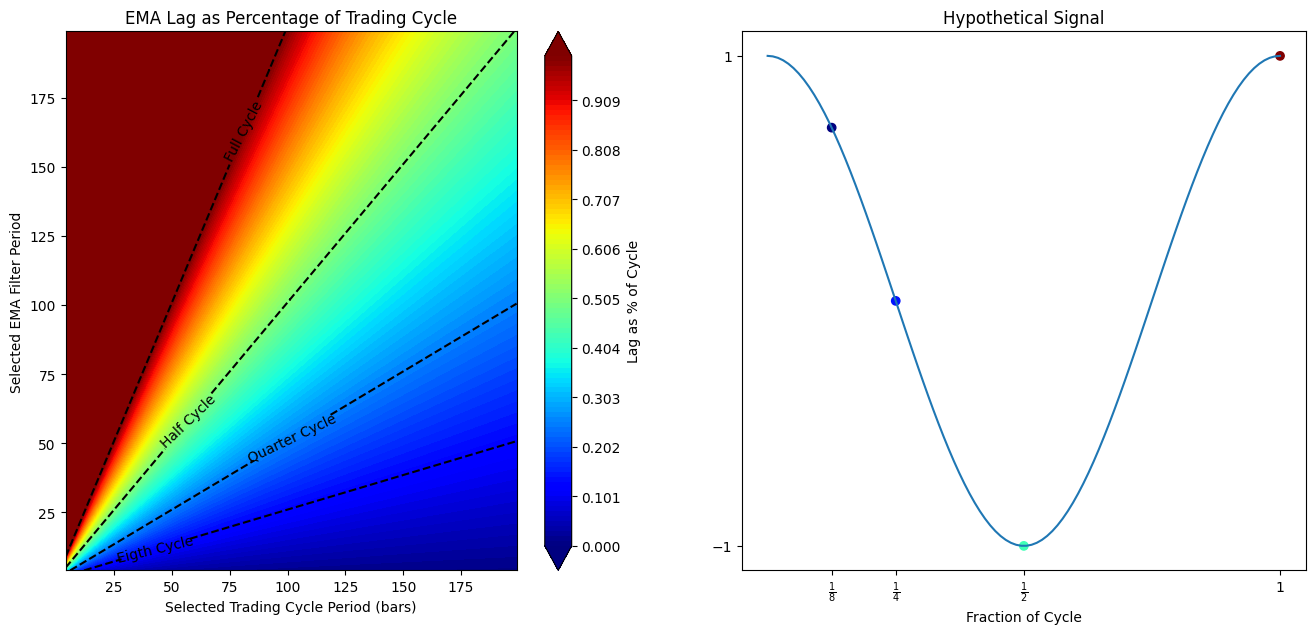

In [175]:
fig, ax = plt.subplots(1, 2, figsize=(16,7))

lookup = {0.125: 'Eigth Cycle', 0.25: 'Quarter Cycle', 0.5: 'Half Cycle', 1.0: 'Full Cycle'}
def fmt(x):
    lab = lookup[x]
    return lab

# Lag Analysis
cont = ax[0].contourf(TP, SP, Lpercent, np.linspace(0.0, 1.0, 100), cmap='jet', extend='both')
line = ax[0].contour(TP, SP, Lpercent, [0.125, 0.25, 0.5, 1.0], colors='k', linestyles='dashed')
ax[0].clabel(line, line.levels, inline=True, fmt=fmt, fontsize=10)
ax[0].set_xlabel('Selected Trading Cycle Period (bars)')
ax[0].set_ylabel('Selected EMA Filter Period')
ax[0].set_title('EMA Lag as Percentage of Trading Cycle')
cbar = plt.colorbar(cont, extend='both')
cbar.set_label('Lag as % of Cycle')

# Hypothetical Signal
theta = np.linspace(0, 2*np.pi, 100)
signal = np.cos(theta)
ax[1].plot(theta, signal)
ax[1].set_yticks([-1, 1])
ax[1].set_xticks([0.125*2*np.pi, 0.25*2*np.pi, 0.5*2*np.pi, 1.0*2*np.pi])
ax[1].set_xticklabels([r"$\frac{1}{8}$", r"$\frac{1}{4}$", r"$\frac{1}{2}$", r"$1$"])
scat = 2*np.pi*np.array([0.125, 0.25, 0.5, 1.0])
ax[1].scatter(scat, np.cos(scat), c=[12.5, 25, 50, 100], cmap='jet')
ax[1].set_xlabel('Fraction of Cycle')
ax[1].set_title('Hypothetical Signal')